In [1]:
import os

os.environ['SPARK_VERSION'] = '3.3'

from pyspark.sql import SparkSession, Row
import pydeequ
from pyspark.sql import SparkSession, Row
import pydeequ
from pyspark.sql import SparkSession
from pydeequ.checks import *
from pydeequ.verification import *
import time
import matplotlib.pyplot as plt
from pydeequ.analyzers import *

# Now, you can proceed with your SparkSession setup and the rest of your code
spark = (SparkSession
    .builder
    .config("spark.jars.packages", pydeequ.deequ_maven_coord)
    .config("spark.jars.excludes", pydeequ.f2j_maven_coord)
    .config("spark.scheduler.maxRegisteredResourcesWaitingTime", "5000")
    .config("spark.scheduler.minRegisteredResourcesRatio", "1.0")
    .config("spark.sql.debug.maxToStringFields", "100")
    .appName("test") \
    .getOrCreate())


In [2]:
df = spark.read.csv("chicago_taxi_trips_2016_01.csv", header=True, inferSchema=True)

In [3]:
import os

# Replace this with the path to your file
file_path = 'chicago_taxi_trips_2016_01.csv'

# Getting the size of the file
file_size = os.path.getsize(file_path)

print(f"The size of the file is: {file_size} bytes")


The size of the file is: 184423109 bytes


In [4]:
affichage = []
for i in range(1,6):
    affichage.append(round(file_size * 0.2 * i))
print(affichage)

[36884622, 73769244, 110653865, 147538487, 184423109]


# Mesure de Completeness sur 3 différentes attributs

#### Attribut (Taxi _id) : il est presque complet
#### Attribut (dropoff_census_tract) : il est a moitié complet
#### Attribut (pickup_census_tract) : beaucoup de missing values

Value: 0.9999794750900897 does not meet the constraint requirement!
Value: 0.9999868019515514 does not meet the constraint requirement!
Value: 0.9999892433267066 does not meet the constraint requirement!
Value: 0.9999875293061306 does not meet the constraint requirement!
Value: 0.999986499415953 does not meet the constraint requirement!
[1.693406343460083, 3.4342100620269775, 12.93751835823059, 33.552730560302734, 70.08064413070679]
[{'check_status': 'Warning', 'check_level': 'Warning', 'constraint_status': 'Failure', 'check': 'Data Completeness Check', 'constraint_message': 'Value: 0.999986499415953 does not meet the constraint requirement!', 'constraint': 'CompletenessConstraint(Completeness(taxi_id,None))'}]


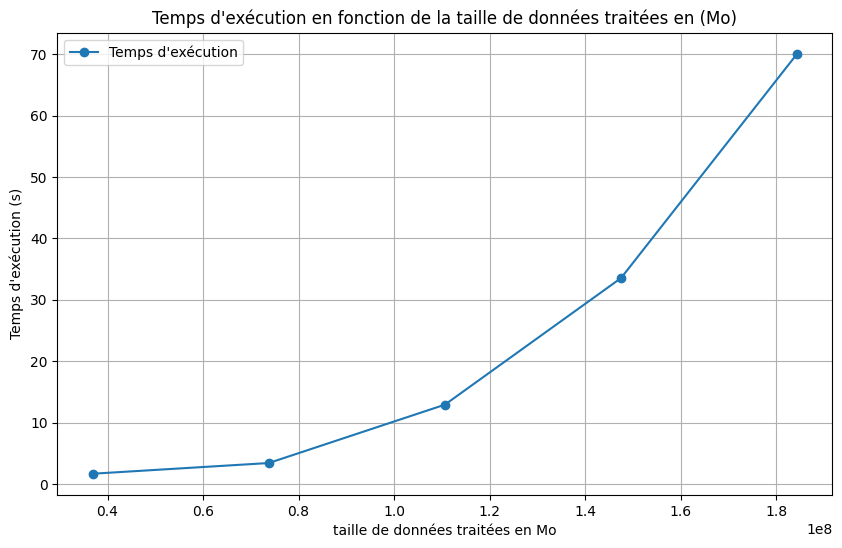

In [5]:
# Charger les données dans un DataFrame Spark
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_batch_complete_tid = []
completeness_results = []

# Au lieu d'initialiser avec une liste vide, utilisez les données existantes et limitez à 0
accumulated_data = data.limit(0)

for i in range(1, 6):
    # Sélectionner le sous-ensemble de données à ajouter
    subset_size = int(total_count * 0.2 * i)
    new_data = data.limit(subset_size).subtract(accumulated_data).cache()
    new_data.count()  # Force le cache et l'évaluation

    # Accumuler les données
    accumulated_data = accumulated_data.union(new_data).cache()

    # Définir la vérification de la complétude
    check = Check(spark, CheckLevel.Warning, "Data Completeness Check")
    
    # Démarrer le chronomètre
    start_time = time.time()
    
    # Exécuter la vérification
    verification_result = VerificationSuite(spark) \
        .onData(accumulated_data) \
        .addCheck(check.isComplete("taxi_id")) \
        .run()
    end_time = time.time()
    elapsed_time = end_time - start_time
    times_batch_complete_tid.append(elapsed_time)  # Ajouter le temps d'exécution à la liste 'times'

    # Détails sur les résultats
    check_results = verification_result.checkResults
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'CompletenessConstraint' in result['constraint']:
                completeness_status = result['constraint_status']  # 'Success' or 'Failure'
                completeness_message = result['constraint_message']
                print(completeness_message)
                if completeness_message != "" :
                # Extract the completeness value from the message
                # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                    completeness_value = float(completeness_message.split('Value: ')[1].split(' ')[0])
                
                    completeness_results.append(completeness_value)

    # Libérer la mémoire
    new_data.unpersist()
    accumulated_data.unpersist()

print(times_batch_complete_tid)
print(check_results)
# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_batch_complete_tid, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

Value: 0.5659274766968969 does not meet the constraint requirement!
Value: 0.567140672132614 does not meet the constraint requirement!
Value: 0.567209161556432 does not meet the constraint requirement!
Value: 0.5670923330174091 does not meet the constraint requirement!
Value: 0.5672411263008986 does not meet the constraint requirement!
[1.174508810043335, 2.6792194843292236, 12.406684160232544, 33.10137152671814, 86.15391540527344]
[{'check_status': 'Warning', 'check_level': 'Warning', 'constraint_status': 'Failure', 'check': 'Data Completeness Check', 'constraint_message': 'Value: 0.5672411263008986 does not meet the constraint requirement!', 'constraint': 'CompletenessConstraint(Completeness(dropoff_census_tract,None))'}]


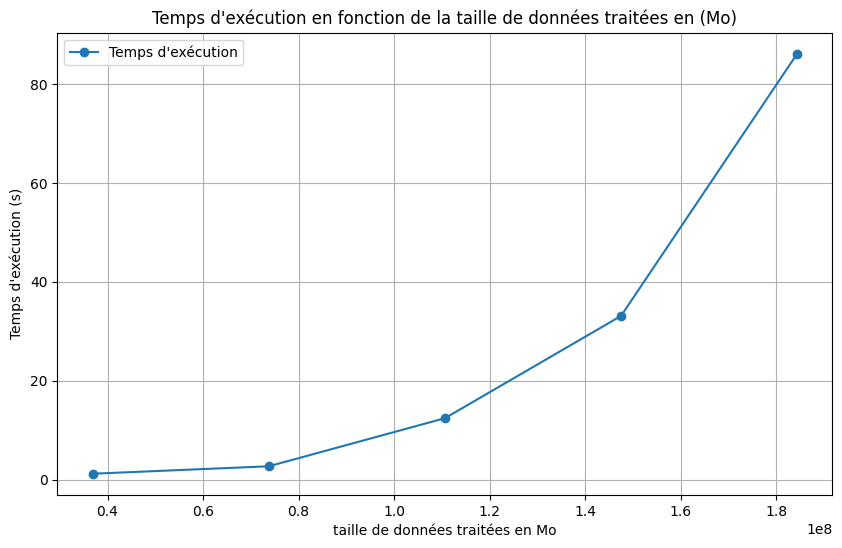

In [6]:
# Charger les données dans un DataFrame Spark
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_batch_complete_dct = []
completeness_results = []

# Au lieu d'initialiser avec une liste vide, utilisez les données existantes et limitez à 0
accumulated_data = data.limit(0)

for i in range(1, 6):
    # Sélectionner le sous-ensemble de données à ajouter
    subset_size = int(total_count * 0.2 * i)
    new_data = data.limit(subset_size).subtract(accumulated_data).cache()
    new_data.count()  # Force le cache et l'évaluation

    # Accumuler les données
    accumulated_data = accumulated_data.union(new_data).cache()

    # Définir la vérification de la complétude
    check = Check(spark, CheckLevel.Warning, "Data Completeness Check")
    
    # Démarrer le chronomètre
    start_time = time.time()
    
    # Exécuter la vérification
    verification_result = VerificationSuite(spark) \
        .onData(accumulated_data) \
        .addCheck(check.isComplete("dropoff_census_tract")) \
        .run()
    end_time = time.time()
    elapsed_time = end_time - start_time
    times_batch_complete_dct.append(elapsed_time)  # Ajouter le temps d'exécution à la liste 'times'

    # Détails sur les résultats
    check_results = verification_result.checkResults
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'CompletenessConstraint' in result['constraint']:
                completeness_status = result['constraint_status']  # 'Success' or 'Failure'
                completeness_message = result['constraint_message']
                print(completeness_message)
                if completeness_message != "" :
                # Extract the completeness value from the message
                # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                    completeness_value = float(completeness_message.split('Value: ')[1].split(' ')[0])
                
                    completeness_results.append(completeness_value)

    # Libérer la mémoire
    new_data.unpersist()
    accumulated_data.unpersist()

print(times_batch_complete_dct)
print(check_results)
# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_batch_complete_dct, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

Value: 0.0 does not meet the constraint requirement!
Value: 0.0 does not meet the constraint requirement!
Value: 0.0 does not meet the constraint requirement!
Value: 0.0 does not meet the constraint requirement!
Value: 0.0 does not meet the constraint requirement!
[1.2165210247039795, 2.7609410285949707, 12.707611799240112, 32.31190371513367, 68.0044596195221]
[{'check_status': 'Warning', 'check_level': 'Warning', 'constraint_status': 'Failure', 'check': 'Data Completeness Check', 'constraint_message': 'Value: 0.0 does not meet the constraint requirement!', 'constraint': 'CompletenessConstraint(Completeness(pickup_census_tract,None))'}]


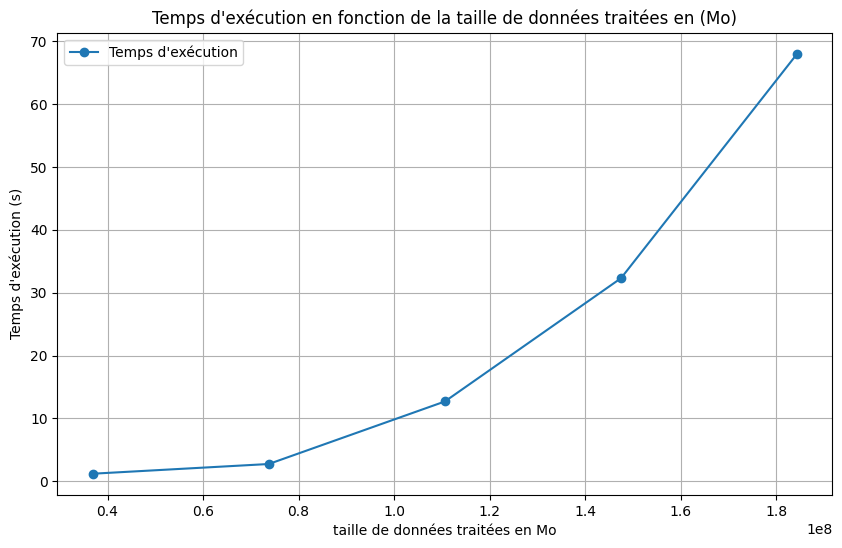

In [7]:
# Charger les données dans un DataFrame Spark
data = df.cache()

# Calculer une fois le nombre total de lignes
total_count = data.count()

# Initialiser les listes pour stocker les résultats
times_batch_complete_pct = []
completeness_results = []

# Au lieu d'initialiser avec une liste vide, utilisez les données existantes et limitez à 0
accumulated_data = data.limit(0)

for i in range(1, 6):
    # Sélectionner le sous-ensemble de données à ajouter
    subset_size = int(total_count * 0.2 * i)
    new_data = data.limit(subset_size).subtract(accumulated_data).cache()
    new_data.count()  # Force le cache et l'évaluation

    # Accumuler les données
    accumulated_data = accumulated_data.union(new_data).cache()

    # Définir la vérification de la complétude
    check = Check(spark, CheckLevel.Warning, "Data Completeness Check")
    
    # Démarrer le chronomètre
    start_time = time.time()
    
    # Exécuter la vérification
    verification_result = VerificationSuite(spark) \
        .onData(accumulated_data) \
        .addCheck(check.isComplete("pickup_census_tract")) \
        .run()
    end_time = time.time()
    elapsed_time = end_time - start_time
    times_batch_complete_pct.append(elapsed_time)  # Ajouter le temps d'exécution à la liste 'times'

    # Détails sur les résultats
    check_results = verification_result.checkResults
    if check_results and isinstance(check_results, list):
        for result in check_results:
            # Ensure the result is for a completeness check
            if 'CompletenessConstraint' in result['constraint']:
                completeness_status = result['constraint_status']  # 'Success' or 'Failure'
                completeness_message = result['constraint_message']
                print(completeness_message)
                if completeness_message != "" :
                # Extract the completeness value from the message
                # This assumes the message contains the value in the format "Value: [completeness_value] does not meet..."
                    completeness_value = float(completeness_message.split('Value: ')[1].split(' ')[0])
                
                    completeness_results.append(completeness_value)

    # Libérer la mémoire
    new_data.unpersist()
    accumulated_data.unpersist()

print(times_batch_complete_pct)
print(check_results)
# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_batch_complete_pct, marker='o', label='Temps d\'exécution')
plt.xlabel('taille de données traitées en Mo')
plt.ylabel('Temps d\'exécution (s)')
plt.title('Temps d\'exécution en fonction de la taille de données traitées en (Mo)')
plt.legend()
plt.grid(True)
plt.show()

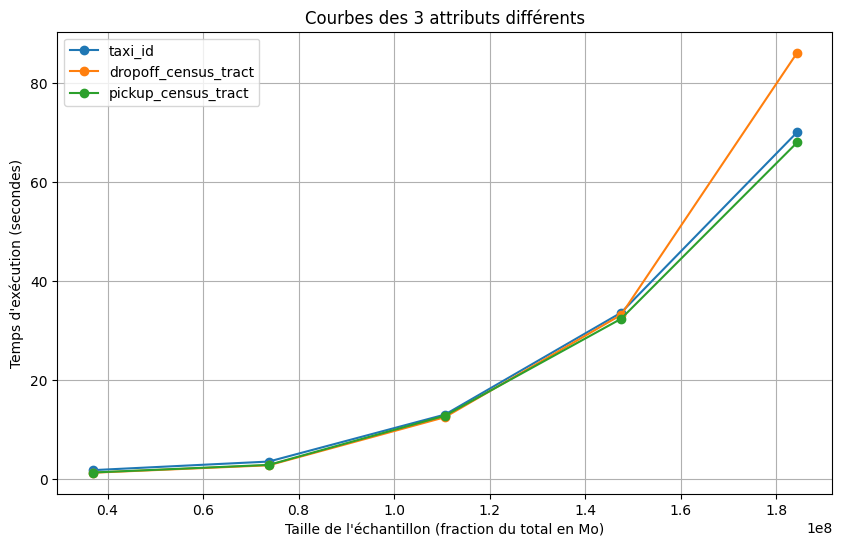

In [8]:
# Création du graphique
plt.figure(figsize=(10, 6))
plt.plot(affichage, times_batch_complete_tid, marker='o',label = "taxi_id")
plt.plot(affichage, times_batch_complete_dct, marker='o',label = "dropoff_census_tract")
plt.plot(affichage, times_batch_complete_pct, marker='o',label = "pickup_census_tract")
plt.title('Temps d\'exécution en fonction de la taille des données')
plt.xlabel('Taille de l\'échantillon (fraction du total en Mo)')
plt.ylabel('Temps d\'exécution (secondes)')
plt.grid(True)
plt.title('Courbes des 3 attributs différents')
plt.legend()
plt.show()